In [1]:
import fastai
from fastai.vision import *
import pretrainedmodels

In [2]:
path = Path('.')

In [3]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [4]:
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat


def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [5]:
def resnext101_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [6]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [7]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [8]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [9]:
(df.has_oilpalm==1).sum()

942

In [10]:
# df = df[df.score>0.85]

In [11]:
N = len(df); N

15244

In [12]:
def get_data(size=128, bs=64, pct=0.2, seed=2019, n_sample=len(df)):
    src = (ImageItemList.from_df(df.sample(n_sample), path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names))
    return (src.transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [14]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True):
    learn = create_cnn(data, 
                       resnext101_32x4d,
                       pretrained=False,
                       metrics=[accuracy])
    if mixup: learn.mixup()
    return learn.to_fp16()

In [15]:
data = get_data(256, 32)

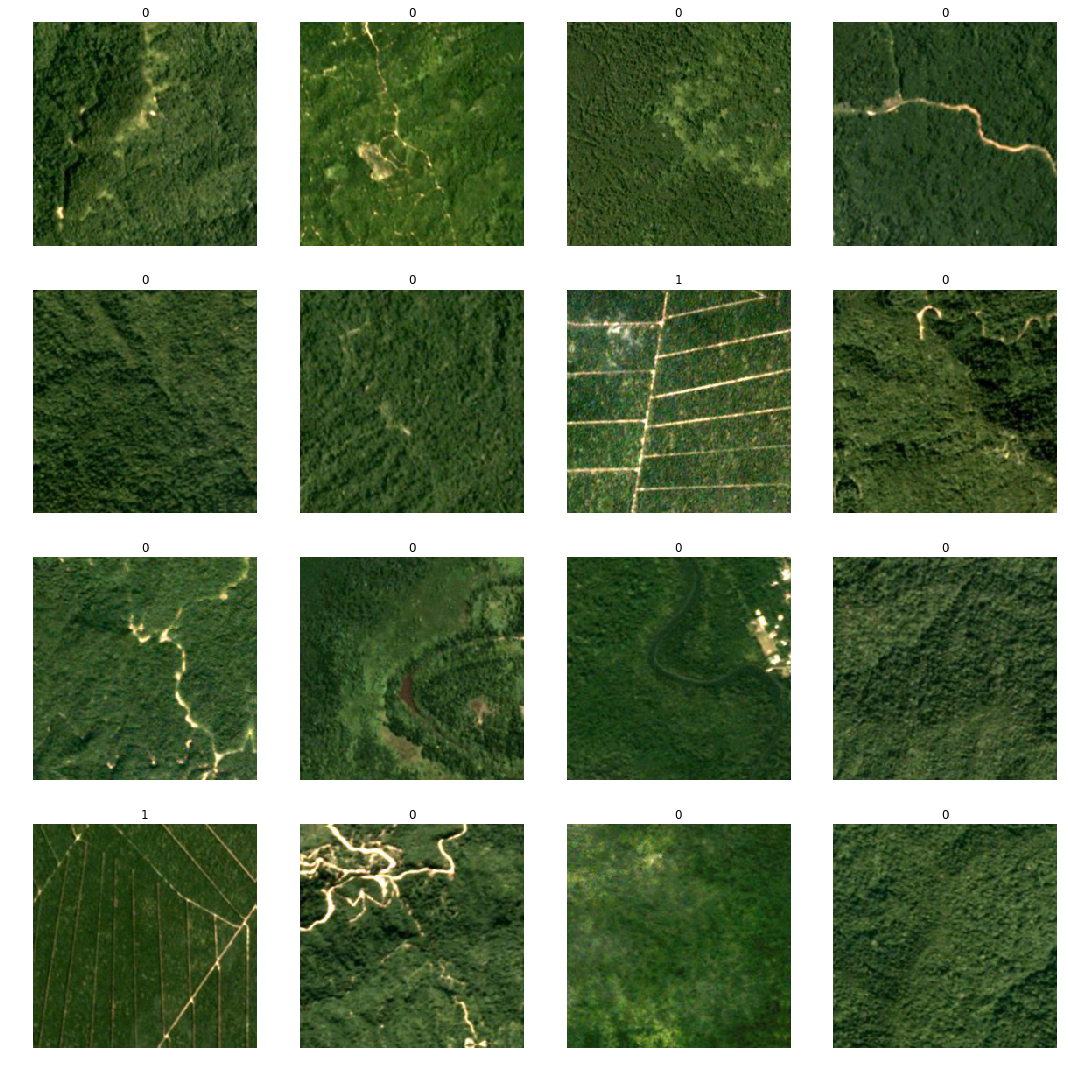

In [16]:
data.show_batch(4, figsize=(15, 15))

In [19]:
learn = get_learner(data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

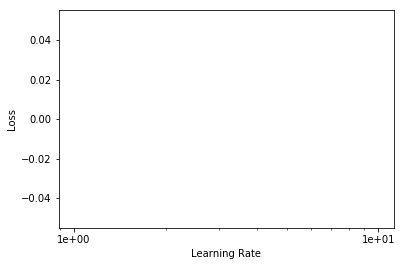

In [20]:
learn.lr_find(); learn.recorder.plot()

In [21]:
lr = 2e-2

256

In [ ]:
learn.fit_one_cycle(12, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.225398,0.244554,0.930118
2,0.270150,0.245743,0.940945
3,0.277951,0.274510,0.940945
4,0.229144,0.248935,0.940945
5,nan,nan,0.940945


In [ ]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, slice(1e-5,1e-4))
learn.save('256u')

In [31]:
learn.to_fp16()
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
auc_score(p,t)

In [48]:
learn = get_learner(get_data(256, 64, 0.01))
learn.load('256u')
learn.model.float()
p,t = learn.TTA(ds_type=DatasetType.Test)

In [49]:
p = to_np(p); p.shape

(6534, 2)

In [50]:
preds = p[:,1]

# X-validation

In [14]:
# sample = 500
f = open("log_101.txt","w+")
folds = 5
preds = 0
for i in range(folds):
    f.write(f'---Fold {i}---\n')
    data = get_data(256, 32, seed=i)
    learn = get_learner(data)
    learn.freeze()
    learn.fit_one_cycle(12, slice(1e-2))
    learn.save(f'256-{i}')
    learn.unfreeze()
    learn.fit_one_cycle(20, slice(1e-6,1e-4))
    learn.save(f'256u-{i}')
    p,t = learn.get_preds()
    f.write(f'  AUC score after fold {i} :{auc_score(p,t)}\n')
    
    #TTA shit
    learn = get_learner(get_data(256, 48))
    learn.load(f'256u-{i}')
    learn.model.float()
    p,t = learn.TTA(ds_type=DatasetType.Test)
    
    preds += to_np(p[:,1])/folds
   
f.close()

In [15]:
np.save('preds_5fold_RX101',preds)

## Sub file

In [16]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [17]:
ids.shape

(6534,)

In [18]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [19]:
sub.to_csv('sub_resneXt101x5_haze_TTA.csv', index=False)

In [24]:
sub.has_oilpalm.asdtype(float)

AttributeError: 'Series' object has no attribute 'asdtype'